# Разметка данных
## Сентимент анализ
  -  Не размечаются данные на иностранном языке
  - Брань - размечается


In [53]:
import pickle
import logging
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)

In [54]:
logging.basicConfig(level=logging.INFO)

raw_path = Path("../data/raw/raw.csv")
interim_path = Path("../data/interim/comments.csv")

cols = ["Комментарии", "Эмоциональная окраска"]
sheet_names = ["UX", "GP", "AS"]

class_labels = {"мусор":0, "негативная": 1, "нейтральная": 2, "позитивная": 3}
class_colors = {0: "blue", 1: "red", 2: "yellow", 3: "green"}

id2label = {v: k for k, v in class_labels.items()}

In [55]:
logging.info("Start reading files")

frames = []
for sheet in sheet_names:
    logging.info(f"Reading sheet: {sheet}")
    df = pd.read_excel(raw_path, sheet_name=sheet, usecols=cols)
    frames.append(df)

result = pd.concat(frames, ignore_index=True)

logging.info(f"Final dataset shape: {result.shape}")

output_path = Path("../data/interim/comments.csv")
result.to_csv(output_path, index=False, encoding="utf-8-sig")

logging.info(f"File saved to {output_path}")

INFO:root:Start reading files
INFO:root:Reading sheet: UX
INFO:root:Reading sheet: GP
INFO:root:Reading sheet: AS
INFO:root:Final dataset shape: (29057, 2)
INFO:root:File saved to ../data/interim/comments.csv


In [56]:
logging.info(f"Reading file: {interim_path}")
df = pd.read_csv(interim_path)

logging.info("Preproccessing emotional marks")
df.columns = ["text", "label"]
df = df.dropna()
df["label"] = df["label"].str.lower().map(class_labels)
df.head()


INFO:root:Reading file: ../data/interim/comments.csv
INFO:root:Preproccessing emotional marks


,text,label
0,Уже регестрировалась,2
1,Вам зачем местоположение?,2
2,Видео нет,1
3,конченые.,1
4,зачем мне это?,2


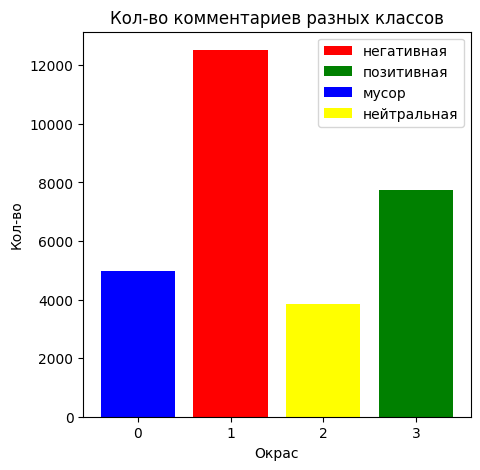

In [57]:
class_values = df["label"].value_counts()

plt.figure(figsize=(5, 5))

for c, count in class_values.items():
    plt.bar(c, count, color=class_colors[c], label=id2label[c])

plt.title("Кол-во комментариев разных классов")
plt.xlabel("Окрас")
plt.ylabel("Кол-во")
plt.legend()
plt.xticks(class_values.index)
plt.savefig("analyze.svg")

In [58]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, stratify=y, shuffle=True
)

pd.concat([X_train, y_train], axis=1).to_csv("../data/output/train.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../data/output/test.csv", index=False)

# Sklearn model's methods
## Fit
Обучение
Составляет словарь
Только на тренировочных данных. Изучает параметры.	Ничего не возвращает (изменяет сам объект).

## Transform
Применение обученной модели
На тренировочных (после fit) и тестовых/новых данных. Применяет преобразование.	Преобразованную матрицу.

## Fit_transform
Комбинация
Только на тренировочных данных. Для удобства и эффективности.	Преобразованную матрицу.

In [70]:
train = pd.read_csv("../data/output/train.csv")
test = pd.read_csv("../data/output/test.csv")

model = TfidfVectorizer()
X_train_vector = model.fit_transform(train["text"])
X_test_vector = model.transform(test["text"])

# Не сходился на 100
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_vector, train["label"])
y_pred = lr.predict(X_test_vector)

print("Accuracy score:", accuracy_score(test["label"], y_pred))
print("Precision score:", precision_score(test["label"], y_pred, average="weighted"))
print("Recall score:", recall_score(test["label"], y_pred, average="weighted"))
print("F1 score:", f1_score(test["label"], y_pred, average="weighted"))

with open("../models/tf_idf_start.pkl", "wb") as file:
    pickle.dump(model, file=file)

with open("../models/lr_start.pkl", "wb") as file:
    pickle.dump(lr, file=file)

Accuracy score: 0.8272539573296628
Precision score: 0.8267726801235966
Recall score: 0.8272539573296628
F1 score: 0.8207081711736681


После предсказания возможны 4 исхода:

True Positive (**TP**): Модель верно предсказала токсичный комментарий
True Negative (**TN**): Модель верно предсказала нетоксичный комментарий
False Positive (**FP**): Модель ошиблась, предсказав токсичность там, где ее нет
False Negative (**FN**): Модель пропустила токсичный комментарий, предсказав его как нетоксичный

### accuracy_score
Измеряет общую долю правильных ответов модели
(TP + TN) / (TP + TN + FP + FN)
Если 90% комментариев нетоксичны, и модель будет всегда предсказывать "0", ее accuracy будет 90%, но она бесполезна!

### precision_score
Измеряет сколько действительно токсичны, из всех предсказанных "токсичных"
TP / (TP + FP)

### recall_score
Измеряет сколько модель обнаружила из всех реально токсичных
TP / (TP + FN)

### f1_score
Измеряет Гармоническое среднее между Precision и Recall - Баланс между точностью предсказаний и полнотой охвата.
2 * (Precision * Recall) / (Precision + Recall)